# driver_monolithic_LSROM
Driver to test and evaluate the monolithic LS-ROM on the 2D Burgers' equation.   

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import dill as pickle
from time import time
import os

from utils.Burgers2D_probgen import Burgers2D
from utils.monolithic_LSROM import monolithic_LSROM, monolithic_LSROM_HR, compute_basis_from_svd
from utils.newton_solve import gauss_newton

In [2]:
data_dir = './data/'
plt.rc('font', size=20)
plt.rcParams['text.usetex'] = True

## Build monolithic FOM

In [3]:
# define constant parameters for PDE
nx, ny  = 480, 24
x_lim   = [-1.0, 1.0]
y_lim   = [0.0, 0.05]

na1, nlam = 80, 80
a1_lim  = [1.0, 10000.0]
lam_lim = [5.0, 25.0]
A, Lam  = np.meshgrid(np.linspace(a1_lim[0], a1_lim[1], na1), np.linspace(lam_lim[0], lam_lim[1], nlam))
Mu      = np.vstack([A.flatten(), Lam.flatten()]).T

a1, lam = 7692.5384, 21.9230
# a1, lam = 1.0, 25.0
# a1, lam = np.trunc(np.random.uniform(1.0, 1e4)*1e4)/1e4, np.trunc(np.random.uniform(5.0, 25.0)*1e4)/1e4
viscosity = 0.1

print(f'a1, lam = {a1, lam}')

# number of subdomains in x and y directions for DD model
n_sub_x = 1
n_sub_y = 1

n_sub   = n_sub_x*n_sub_y
Ntotal = 6400 if nx in [240, 480] else 4200
fig_dir0 = f'./figures/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
fig_dir  = fig_dir0+f'a1_{a1}_lam_{lam}/'
svd_dir  = f'./data/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
ls_figs = fig_dir + 'lsrom/'
for d in [fig_dir0, fig_dir, ls_figs, svd_dir]:
    if not os.path.exists(d):
        os.mkdir(d)

a1, lam = (7692.5384, 21.923)


In [4]:
# compute FOM for given a1 and lambda
def u_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val = -2.0*viscosity*(a1 + lam*(np.exp(lam*(x-1.0)) \
          - np.exp(-lam*(x - 1.0)))*np.cos(lam*y))/phi
    return val
def v_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val =  2.0*viscosity*(lam*(np.exp(lam*(x-1.0)) \
           + np.exp(-lam*(x - 1.0)))*np.sin(lam*y))/phi
    return val

# generate Burgers FOM on full domain
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity, u_exact, v_exact)
print('Solving full domain model:')
start = time()
u_fom, v_fom, res_hist = fom.solve(np.zeros(fom.nxy), np.zeros(fom.nxy), tol=1e-8, print_hist=True)
fom_time = time()-start
sol_fd = np.concatenate([u_fom, v_fom])

Solving full domain model:
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      5.007e+06
   1       1.000e+00      1.764e+05
   2       1.000e+00      2.570e+04
   3       1.000e+00      2.397e+03
   4       1.000e+00      2.035e+02
   5       1.000e+00      1.730e+01
   6       1.000e+00      1.478e+00
   7       1.000e+00      1.268e-01
   8       1.000e+00      1.095e-02
   9       1.000e+00      9.516e-04
  10       1.000e+00      8.342e-05
  11       1.000e+00      7.379e-06
  12       1.000e+00      6.594e-07
  13       1.000e+00      5.962e-08
  14       1.000e+00      5.913e-09
Newton solver terminated after 14 iterations with residual 5.9127e-09.


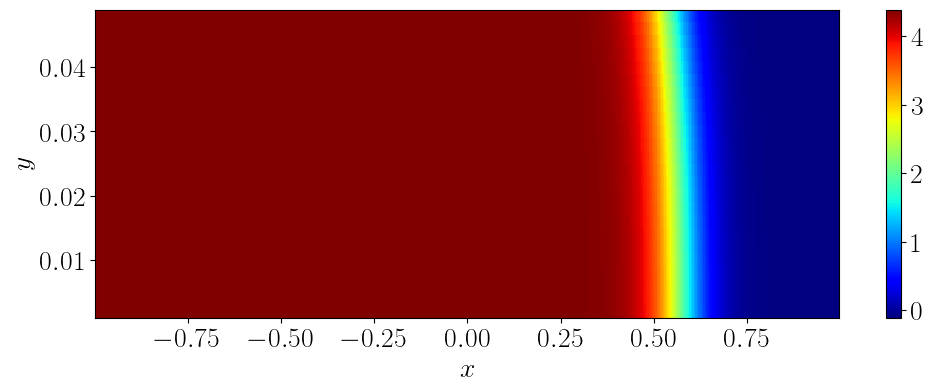

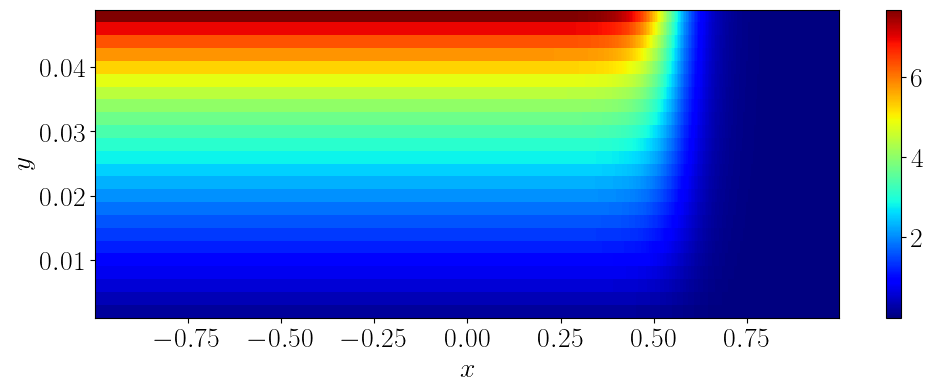

In [5]:
# plot DD FOM u and v
x = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y = np.meshgrid(x, y)
U_fom = u_fom.reshape(ny, nx)
V_fom = v_fom.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_fom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = fig_dir+'u_fom.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_fom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = fig_dir+'v_fom.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Compute POD basis

In [22]:
# energy criteria for number of interior and interface basis vectors
ec_res   = 1e-8
ec_state = 1e-6

# number of interior and interface basis vectors. set to -1 to use energy criteria
nbasis_res  = -1
nbasis_state = 10

In [23]:
# compute SVD for snapshots/residuals for each subdomain 
nsnaps = Ntotal
if not os.path.exists(svd_dir+f'state_svd_nsnaps_{nsnaps}.p'):
    # load snapshot and residual data
    print('Loading snapshot data...')
    file = f'./data/residual_nx_{nx}_ny_{ny}_mu_{viscosity}_Nsamples_400.p'
    data = pickle.load(open(file, 'rb'))
    Mu = data['parameters']
    residuals = data['residuals']

    # load snapshot and residual data
    file = f'./data/snapshot_nx_{nx}_ny_{ny}_mu_{viscosity}_Nsamples_{Ntotal}.p'
    data = pickle.load(open(file, 'rb'))
    Mu = data['parameters']
    snapshots = data['snapshots']
    print('Data loaded!')
    
    # gets indices for training snapshots
    if nsnaps>=0:
        idx = np.linspace(0, len(snapshots), num=nsnaps, endpoint=False, dtype=int)
        snapshots = np.vstack(snapshots)[idx]
    
    Nsnaps = len(snapshots)
    Nres   = len(residuals)
    
    # sets file names
    res_file =svd_dir+f'res_svd.p'
    state_file=svd_dir+f'state_svd_nsnaps_{Nsnaps}.p'        
    
    print(f'Computing state SVD...')
    state_leftvecs, state_singvals, vh_state = la.svd(snapshots.T, full_matrices=False, check_finite=False)
    print('Done!')
    
    print('Saving state SVD data...')
    state_dict = {'left_vecs': state_leftvecs, 
                 'sing_vals': state_singvals}
    pickle.dump(state_dict, open(state_file,'wb'))
    print('State SVD data saved!')
    
    print(f'Computing residual SVD...')
    res_leftvecs, res_singvals, vh_res = la.svd(np.vstack(residuals).T, full_matrices=False, check_finite=False)
    print('Done!')  

    # saves data
    print('Saving residual SVD data...')
    res_dict = {'left_vecs': res_leftvecs, 
                'sing_vals': res_singvals}
    pickle.dump(res_dict, open(res_file,'wb'))    
    print('Residual SVD data saved!')
    
else:
    # load SVD data
    print('Loading SVD data...')
    state_dict = pickle.load(open(svd_dir+f'state_svd_nsnaps_{nsnaps}.p', 'rb'))
    res_dict   = pickle.load(open(svd_dir+'res_svd.p', 'rb'))
    print('Data loaded!')


Loading SVD data...
Data loaded!


In [24]:
# compute bases
print('Computing state and residual bases...')
state_basis = compute_basis_from_svd(state_dict, ec=ec_state, nbasis=nbasis_state)
res_basis = compute_basis_from_svd(res_dict, ec=ec_res, nbasis=nbasis_res)
print('Bases computed!')

Computing state and residual bases...
Bases computed!


## Construct LS-ROM class

## Solve LS-ROM

In [25]:
# compute LS-ROM
lsrom = monolithic_LSROM(fom, state_basis)

In [26]:
# solve lsrom
w0 = np.zeros(lsrom.n_state)
start = time()
w, res_hist, step_hist, iter = lsrom.solve(w0, tol=1e-3, maxit=15, print_hist=True)
rom_time = time()-start
lsrom_rel_err = np.linalg.norm(sol_fd-lsrom.basis@w)/np.linalg.norm(sol_fd)
print(f'DD-ROM rel. error = {lsrom_rel_err:1.4e}')
print(f'Speedup = {fom_time/rom_time}')

iter       Stepsize       ||RTr||
   0       0.000e+00      8.403e+10
   1       1.000e+00      4.232e+09
   2       1.000e+00      1.457e+07
   3       1.000e+00      4.361e+02
   4       1.000e+00      1.178e-01
   5       1.000e+00      3.282e-05
DD-ROM rel. error = 4.2863e-03
Speedup = 15.11720881116579


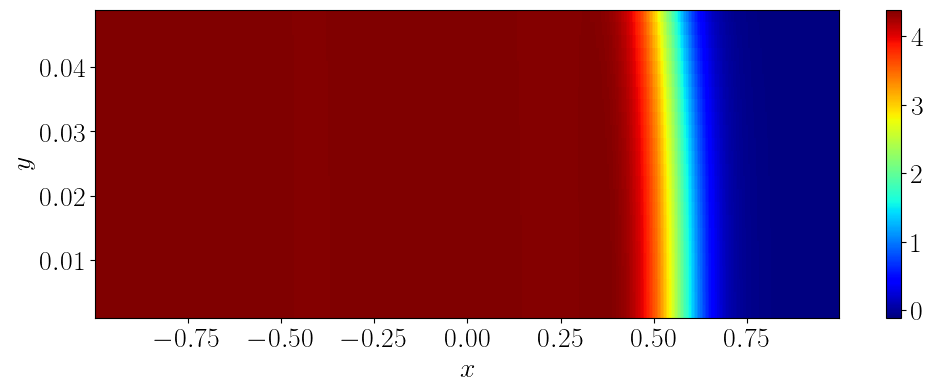

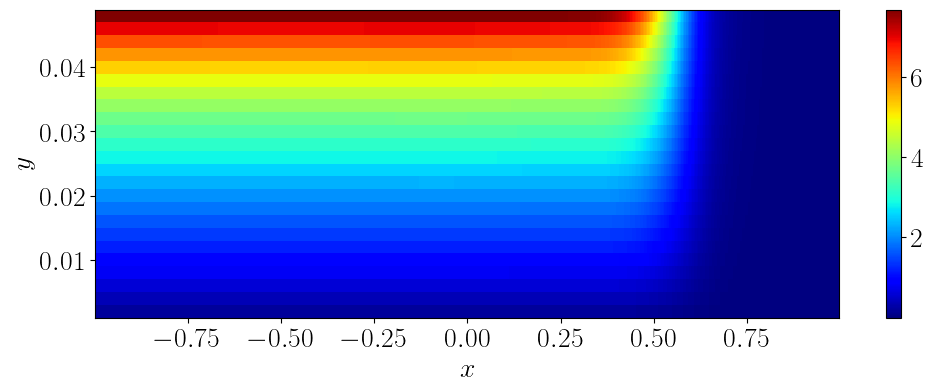

In [27]:
# plot rom solutions
u_rom = lsrom.u_basis@w
v_rom = lsrom.v_basis@w
U_rom = u_rom.reshape(ny, nx)
V_rom = v_rom.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_rom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = ls_figs+'u_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_rom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = ls_figs+'v_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

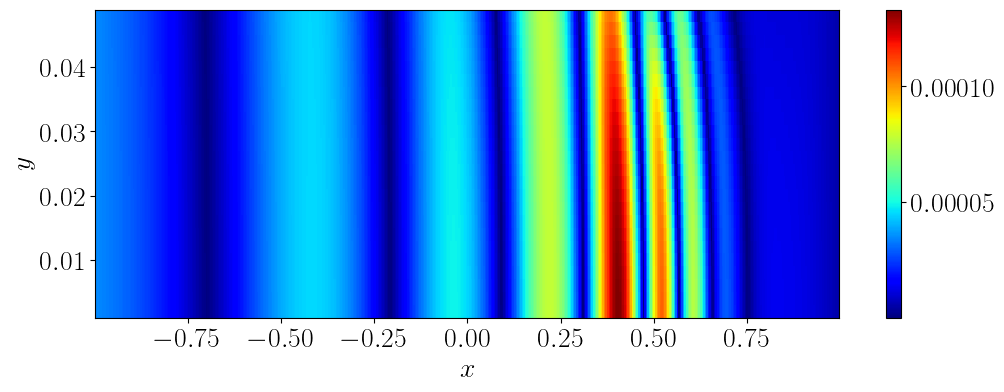

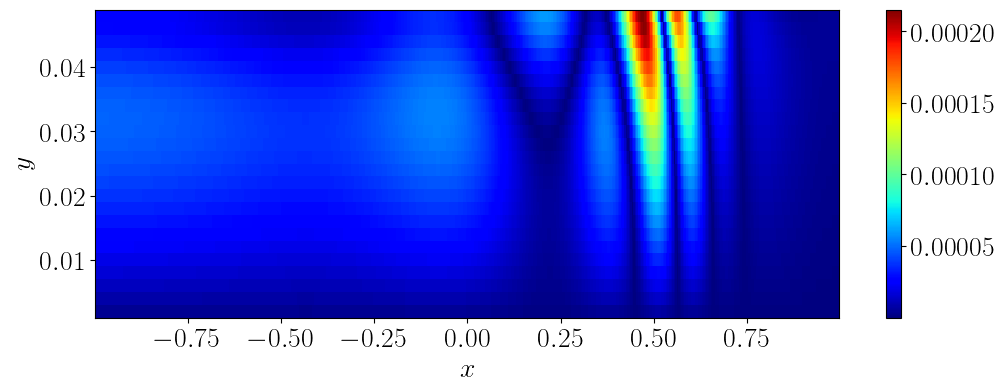

In [28]:
# plot errors
u_rel_err = np.abs(U_fom-U_rom)/np.linalg.norm(U_fom)
plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, u_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u$ Relative error')
file = ls_figs+f'u_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
v_rel_err = np.abs(V_fom-V_rom)/np.linalg.norm(V_fom)
plt.pcolormesh(X, Y, v_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v$ Relative error')
file = ls_figs+f'v_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Implement LS-ROM with HR

In [29]:
# compute LS-ROM
lsromhr = monolithic_LSROM_HR(fom, state_basis, res_basis, sample_ratio=2, n_samples=-1)

In [30]:
# solve lsrom
w0 = np.zeros(lsromhr.n_state)
start = time()
w_hr, res_hist, step_hist, iter = lsromhr.solve(w0, tol=1e-3, maxit=15, print_hist=True)
hr_rom_time = time()-start
lsromhr_rel_err = np.linalg.norm(sol_fd-lsromhr.basis@w_hr)/np.linalg.norm(sol_fd)
print(f'DD-ROM rel. error = {lsromhr_rel_err:1.4e}')
print(f'Speedup = {fom_time/hr_rom_time}')

iter       Stepsize       ||RTr||
   0       0.000e+00      3.814e+09
   1       1.000e+00      1.618e+08
   2       1.000e+00      4.413e+05
   3       1.000e+00      4.257e+01
   4       1.000e+00      1.022e-02
   5       5.000e-01      5.108e-03
   6       2.500e-01      3.831e-03
   7       1.250e-01      3.352e-03
   8       7.629e-06      3.352e-03
   9       5.821e-11      3.352e-03
No stepsize found at iteration 9.
DD-ROM rel. error = 5.3624e-03
Speedup = 24.446748123701845


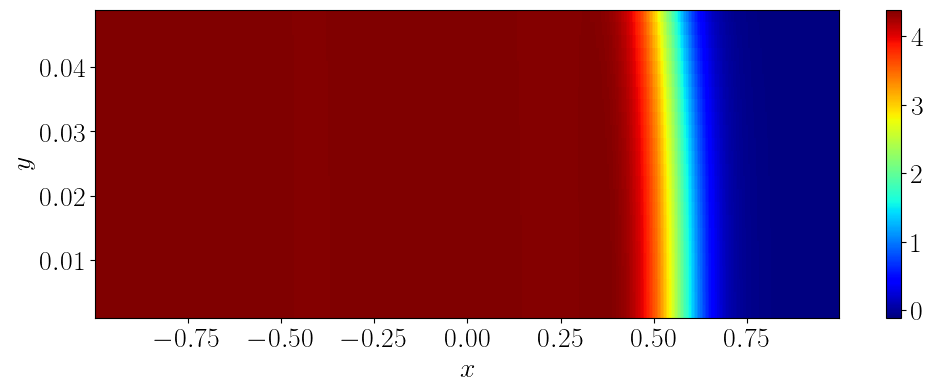

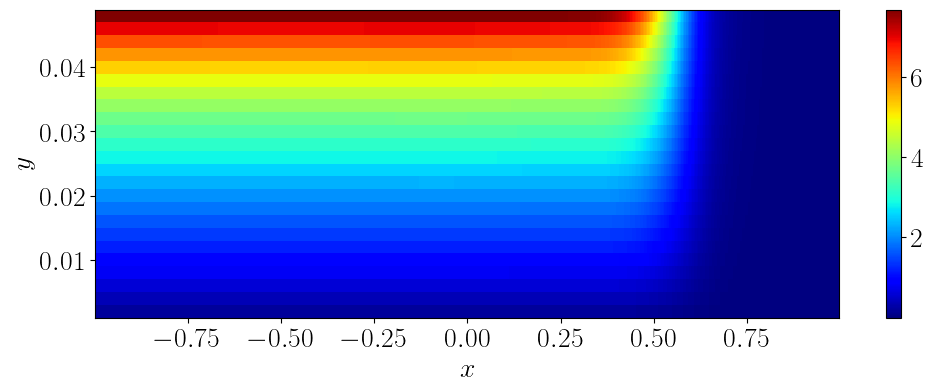

In [31]:
# plot rom solutions
u_rom = lsromhr.u_basis@w
v_rom = lsromhr.v_basis@w
U_rom = u_rom.reshape(ny, nx)
V_rom = v_rom.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_rom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = ls_figs+'u_col_hr_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_rom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = ls_figs+'v_col_hr_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

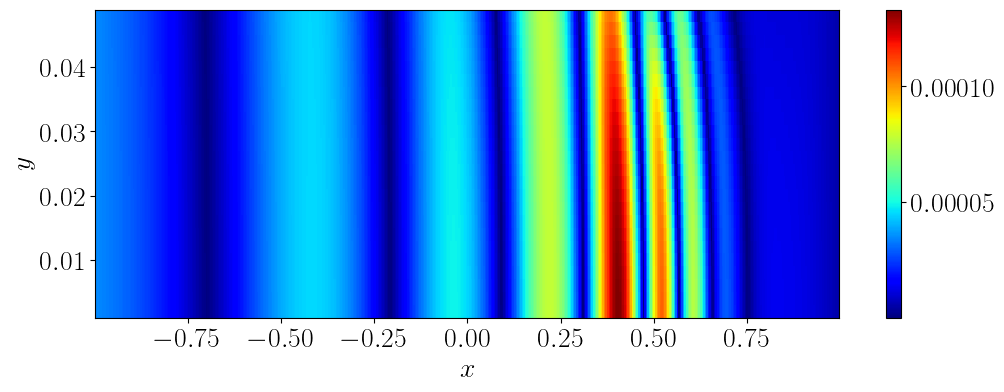

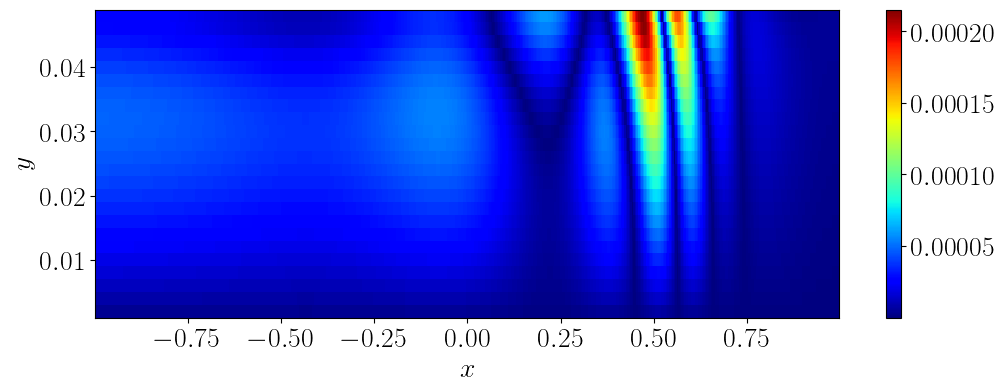

In [32]:
# plot errors
u_rel_err = np.abs(U_fom-U_rom)/np.linalg.norm(U_fom)
plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, u_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u$ Relative error')
file = ls_figs+f'u_col_hr_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
v_rel_err = np.abs(V_fom-V_rom)/np.linalg.norm(V_fom)
plt.pcolormesh(X, Y, v_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v$ Relative error')
file = ls_figs+f'v_col_hr_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Compute FOM residual at ROM solution

In [34]:
uv = lsromhr.basis@w_hr
u, v = uv[:fom.nxy], uv[fom.nxy:]
r = fom.residual(u, v)
np.linalg.norm(r/fom.nxy)

1.6381241864572647